In [1]:
# =============================================================================
#  RANDOM FOREST FORECASTING - 4 Horizons (train_df → test_df → final_df)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings
#warnings.filterwarnings("ignore", message=".*unknown categories.*")

In [3]:
# 1: Load datasets
print(" Loading datasets...")
train_df = pd.read_csv("train_df.csv", sep=",")  # 2021-2023
test_df = pd.read_csv("test_df.csv", sep=",")    # 2024 only  
#final_df = pd.read_csv("final_df.csv", sep=",")  # All data

# Sort consistently
sort_cols = ["date", "logistieke location id", "crop_type", "fpc_index", "horizon"]
train_df = train_df.sort_values(sort_cols).reset_index(drop=True)
test_df  = test_df.sort_values(sort_cols).reset_index(drop=True)

print(f"Train: {train_df.shape} | Test: {test_df.shape} ")


 Loading datasets...
Train: (513649, 420) | Test: (170647, 420) 


In [4]:
for col in ["curr_month", "curr_weekday", "curr_weekofyear", "target_month", "target_weekday", "target_weekofyear"]:
    train_df[col] = train_df[col].astype("category")
    test_df[col]  = test_df[col].astype("category")
    test_df[col] = test_df[col].cat.set_categories(train_df[col].cat.categories)

In [5]:
# -------------------------------------------------------------------
# 2: Preprocessing (handles all 3 datasets)
# -------------------------------------------------------------------
target = "trolleys_target"    # train_df, test_df 
#TARGET_COL_FINAL = "trolleys_target"         # final_df (horizon predictions)


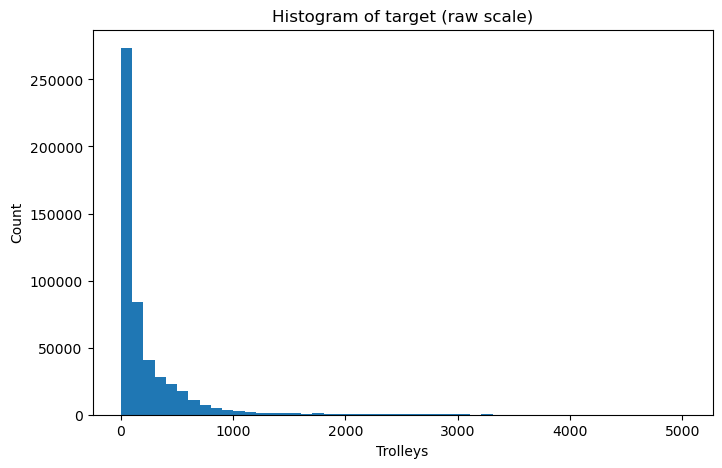

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(train_df[target], bins=50)
plt.xlabel("Trolleys")
plt.ylabel("Count")
plt.title("Histogram of target (raw scale)")
plt.show()

In [7]:

X_train = train_df.drop(columns=[target])
y_train = np.log1p(train_df[target])

X_test = test_df.drop(columns=[target])
y_test = np.log1p(test_df[target])


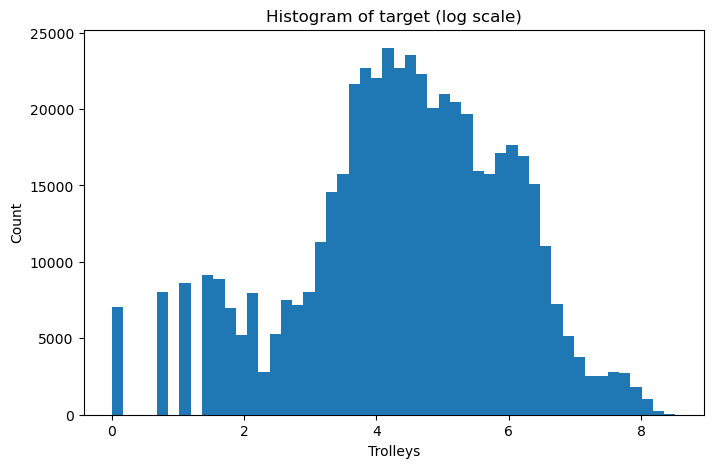

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=50)
plt.xlabel("Trolleys")
plt.ylabel("Count")
plt.title("Histogram of target (log scale)")
plt.show()

In [9]:
# Drop columns that should never be features

# Drop columns that should never be features
drop_cols = []
for c in ["date", "target_date"]:
    if c in X_train.columns:
        drop_cols.append(c)
X_train_features = X_train.drop(columns=["date", "target_date"])
X_test_features  = X_test.drop(columns=["date", "target_date"])

In [10]:
# Same preprocessing pipeline
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns

numeric_pipeline = Pipeline([
    ("zv", VarianceThreshold(threshold=0.001)),
    ("normalize", StandardScaler())
])
categorical_pipeline = Pipeline([
    ("dummy", OneHotEncoder(
        drop="first", 
        sparse_output=False, 
        handle_unknown='infrequent_if_exist',
        min_frequency=1
    ))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])


In [11]:
# -------------------------------------------------------------------
# 3: Rolling_panel_cv
# -------------------------------------------------------------------
def rolling_panel_cv(df, time_col, n_folds, train_blocks):
    # unique, sorted time points from the date column
    times = np.sort(df[time_col].unique())

    # split time points into blocks
    blocks = np.array_split(times, n_folds + train_blocks)

    for i in range(n_folds):
        # define training and test blocks
        train_times = np.concatenate(blocks[i : i + train_blocks])
        test_times = blocks[i + train_blocks]

        # boolean masks for rows belonging to the selected times
        train_mask = df[time_col].isin(train_times)
        test_mask  = df[time_col].isin(test_times)

        # get integer positions for sklearn
        train_idx = np.flatnonzero(train_mask)
        test_idx  = np.flatnonzero(test_mask)

        yield train_idx, test_idx



In [13]:
# -------------------------------------------------------------------
# 4. Train Model
# -------------------------------------------------------------------

print("\n Tuning RF model with 1SE rule...")
cv = list(rolling_panel_cv(
    X_train,
    time_col="date",
    n_folds=5,
    train_blocks=2
))

# Base RF model
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,  
    warm_start=False
)

# RF-specific hyperparameter distributions
rf_param_distributions = {
    'rf__n_estimators': randint(25, 100),        
    'rf__max_depth': [6, 8, 10, None],       
    'rf__min_samples_split': randint(50, 100),  
    'rf__min_samples_leaf': randint(25, 70),    
    'rf__max_features': ['sqrt', 0.3, 0.4, 0.5] 
}

# Pipeline with your preprocessor
rf_pipe = Pipeline([
    ("preprocess", preprocess),  
    ("rf", rf)
])

# RandomizedSearchCV with time-safe CV
rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_distributions,
    n_iter=15,                      # 15 random combinations
    scoring="neg_mean_squared_error",
    cv=cv,                          # Your rolling_panel_cv folds
    n_jobs=1,                       
    verbose=1,
    random_state=42,
    error_score="raise"
)

# Run search
rf_search.fit(X_train, y_train)  # Processed features

# 1SE Rule Analysis
rf_results = pd.DataFrame(rf_search.cv_results_)
rf_results["mean_mse"] = -rf_results["mean_test_score"]
rf_results["se_mse"] = rf_results["std_test_score"] / np.sqrt(len(cv))

best_idx = rf_results["mean_mse"].idxmin()
best_row = rf_results.loc[best_idx]
threshold = best_row["mean_mse"] + best_row["se_mse"]

within_1se = rf_results[rf_results["mean_mse"] <= threshold].copy()

def rf_complexity_key(row):
    """Simpler RF preferred within 1SE"""
    ne = int(row["param_rf__n_estimators"])
    md = row["param_rf__max_depth"]
    md_val = 999 if pd.isna(md) else int(md)
    mss = int(row["param_rf__min_samples_split"])
    msl = int(row["param_rf__min_samples_leaf"])
    mf = float(row["param_rf__max_features"])
    return (ne, md_val, -mss, -msl, mf)  # Smaller trees, more regularization first

within_1se["rf_ckey"] = within_1se.apply(rf_complexity_key, axis=1)
chosen_rf = within_1se.sort_values("rf_ckey").iloc[0]

# Final model with simplest 1SE params
rf_model = rf_search.best_estimator_.set_params(**chosen_rf["params"])
rf_model.fit(X_train, y_train)

print("\n RF Tuning Complete!")
print("Best params:", rf_search.best_params_)
print("Best CV MSE:", best_row["mean_mse"])
print("1SE threshold:", threshold)
print("Chosen 1SE params:", chosen_rf["params"])
print("Chosen 1SE MSE:", chosen_rf["mean_mse"])
print("Model ready for predictions!")




 Tuning RF model with 1SE rule...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\katy1\miniconda3\envs\py312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\katy1\miniconda3\envs\py312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\katy1\miniconda3\envs\py312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\katy1\miniconda3\envs\py312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\katy1\m


 RF Tuning Complete!
Best params: {'rf__max_depth': None, 'rf__max_features': 0.4, 'rf__min_samples_leaf': 68, 'rf__min_samples_split': 52, 'rf__n_estimators': 75}
Best CV MSE: 0.3899065419092437
1SE threshold: 0.42588828183723093
Chosen 1SE params: {'rf__max_depth': 10, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 60, 'rf__min_samples_split': 89, 'rf__n_estimators': 48}
Chosen 1SE MSE: 0.4084354061623814
Model ready for predictions!


In [16]:
#X_test_for_pred = X_test_features if "X_test_features" in globals() else X_test

# Predict in log-space
y_pred_log = rf_model.predict(X_test)

# Back-transform to raw scale (log1p -> raw)
y_pred = np.expm1(y_pred_log)

# True target on raw scale
# If you still have test_df[target] on raw scale, use it
y_true = test_df[target].values if "test_df" in globals() else np.expm1(y_test)

# Build table for analysis /// keep key columns + preds
key_cols = ["date", "logistieke location id", "crop_type", "fpc_index", "horizon", "is_holiday"]
key_cols = [c for c in key_cols if c in (X_test.columns if "X_test" in globals() else test_df.columns)]

test_with_preds = (X_test[key_cols].copy() if "X_test" in globals() else test_df[key_cols].copy())
test_with_preds["y_true"] = y_true
test_with_preds["y_pred"] = y_pred

print("test_with_preds shape:", test_with_preds.shape)
display(test_with_preds.head(10))

C:\Users\katy1\miniconda3\envs\py312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


test_with_preds shape: (170647, 8)


,date,logistieke location id,crop_type,fpc_index,horizon,is_holiday,y_true,y_pred
0,2023-10-24,Aalsmeer,BL,fpc_1,50,True,353.0,182.832334
1,2023-10-24,Aalsmeer,BL,fpc_10,50,True,189.0,367.183245
2,2023-10-24,Aalsmeer,BL,fpc_12,50,True,80.0,36.197783
3,2023-10-24,Aalsmeer,BL,fpc_13,50,True,280.0,171.465968
4,2023-10-24,Aalsmeer,BL,fpc_16,50,True,501.0,342.002673
5,2023-10-24,Aalsmeer,BL,fpc_17,50,True,274.0,206.926289
6,2023-10-24,Aalsmeer,BL,fpc_2,50,True,68.0,56.304580
7,2023-10-24,Aalsmeer,BL,fpc_22,50,True,2907.0,2249.939507
8,2023-10-24,Aalsmeer,BL,fpc_23,50,True,1757.0,1609.446600
9,2023-10-24,Aalsmeer,BL,fpc_24,50,True,36.0,38.766242


In [32]:
def regression_metrics(y_true, y_pred, compute_mape=True, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    metrics = {"MAE": mae, "RMSE": rmse}

    if compute_mape:
        # MAPE safe: includes zeros safely
        denom_safe = np.maximum(np.abs(y_true), eps)
        metrics["MAPE_safe"] = np.mean(np.abs((y_true - y_pred) / denom_safe)) * 100

        # MAPE nonzero: only non-zero y_true
        mask_nonzero = np.abs(y_true) > eps
        if mask_nonzero.sum() > 0:
            metrics["MAPE_nonzero"] = np.mean(
                np.abs((y_true[mask_nonzero] - y_pred[mask_nonzero]) / np.abs(y_true[mask_nonzero]))
            ) * 100
        else:
            metrics["MAPE_nonzero"] = np.nan

    return metrics


In [34]:
print("\n TEST PERFORMANCE:")

# Predict in log space
y_pred_log = rf_model.predict(X_test)

# Back-transform to raw scale (safe clipping)
y_pred_raw = np.expm1(np.clip(y_pred_log, 0, 8))
y_true_raw = np.expm1(np.clip(y_test, 0, 8))

# Add predictions to test dataframe
test_with_preds = X_test.copy()
test_with_preds["rf_pred_log"] = y_pred_log
test_with_preds["rf_pred_raw"] = y_pred_raw
test_with_preds["y_true_raw"] = y_true_raw

print("test_with_preds shape:", test_with_preds.shape)
display(test_with_preds.head(10))

# ------------------------------
# FPC-LEVEL METRICS (row-level)
# ------------------------------
fpc_metrics = regression_metrics(
    test_with_preds["y_true_raw"],
    test_with_preds["rf_pred_raw"]
)

print("FPC-level (raw):")
print(
    f"MAE: {fpc_metrics['MAE']:.0f} | "
    f"RMSE: {fpc_metrics['RMSE']:.1f} | "
    f"MAPE_safe: {fpc_metrics['MAPE_safe']:.1f}% | "
    f"MAPE_nonzero: {fpc_metrics['MAPE_nonzero']:.1f}%"
)

# ------------------------------
# CROP-LEVEL METRICS (aggregated by date/location/crop)
# ------------------------------
group_cols = ["date", "logistieke location id", "crop_type"]

agg_test = (
    test_with_preds
    .groupby(group_cols, as_index=False)
    .agg({
        "y_true_raw": "sum",
        "rf_pred_raw": "sum"
    })
)

# Compute crop-level metrics using regression_metrics
crop_metrics = regression_metrics(
    agg_test["y_true_raw"],
    agg_test["rf_pred_raw"]
)

print("\nCROP-LEVEL (daily totals):")
print(
    f"MAE: {crop_metrics['MAE']:.0f} | "
    f"RMSE: {crop_metrics['RMSE']:.0f} | "
    f"MAPE_safe: {crop_metrics['MAPE_safe']:.1f}% | "
    f"MAPE_nonzero: {crop_metrics['MAPE_nonzero']:.1f}%"
)
print(f"(n={len(agg_test)} daily crop/location totals)")



 TEST PERFORMANCE:


C:\Users\katy1\miniconda3\envs\py312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


test_with_preds shape: (170647, 422)


,date,logistieke location id,crop_type,fpc_index,3_avg_price_per_item_lag_1,3_avg_revenue_per_transaction_lag_1,3_items_sold_cv_lag_1,3_items_sold_mean_lag_1,3_items_sold_std_lag_1,3_n_rows_lag_1,...,is_allsoulsday_window,is_easter_monday_window,is_whit_monday_window,is_ascension_day_window,is_mothersday_fr_window,is_mothersday_uk_window,is_holiday,rf_pred_log,rf_pred_raw,y_true_raw
0,2023-10-24,Aalsmeer,BL,fpc_1,0.37,153.35,1.22,22783.33,27805.08,3.0,...,0,0,0,0,0,0,True,5.214024,182.832334,353.0
1,2023-10-24,Aalsmeer,BL,fpc_10,0.20,191.20,1.20,4443.81,5313.16,16.0,...,0,0,0,0,0,0,True,5.908581,367.183245,189.0
2,2023-10-24,Aalsmeer,BL,fpc_12,0.24,130.29,1.12,1900.00,2121.32,2.0,...,0,0,0,0,0,0,True,3.616249,36.197783,80.0
3,2023-10-24,Aalsmeer,BL,fpc_13,0.24,73.36,2.16,30315.62,65556.04,8.0,...,0,0,0,0,0,0,True,5.150200,171.465968,280.0
4,2023-10-24,Aalsmeer,BL,fpc_16,0.78,356.79,1.23,14174.29,17480.58,7.0,...,0,0,0,0,0,0,True,5.837738,342.002673,501.0
5,2023-10-24,Aalsmeer,BL,fpc_17,0.57,265.31,1.20,48380.00,57841.33,2.0,...,0,0,0,0,0,0,True,5.337184,206.926289,274.0
6,2023-10-24,Aalsmeer,BL,fpc_2,1.37,357.64,0.00,3905.00,0.00,1.0,...,0,0,0,0,0,0,True,4.048381,56.304580,68.0
7,2023-10-24,Aalsmeer,BL,fpc_22,0.27,172.03,1.00,42610.00,42560.48,6.0,...,0,0,0,0,0,0,True,7.719103,2249.939507,2907.0
8,2023-10-24,Aalsmeer,BL,fpc_23,0.34,321.18,1.45,7639.23,11077.52,60.0,...,0,0,0,0,0,0,True,7.384267,1609.446600,1757.0
9,2023-10-24,Aalsmeer,BL,fpc_24,1.24,162.00,1.38,9494.50,13144.41,2.0,...,0,0,0,0,0,0,True,3.683018,38.766242,36.0


FPC-level (raw):
MAE: 50 | RMSE: 101.5 | MAPE_safe: 6558847394.2% | MAPE_nonzero: 47.4%

CROP-LEVEL (daily totals):
MAE: 11239 | RMSE: 16727 | MAPE_safe: 9.1% | MAPE_nonzero: 9.1%
(n=305 daily crop/location totals)


In [35]:
# -------------------------------------------------------------------
# 6. Final predictions on all horizons (final_df)
# -------------------------------------------------------------------

print("\nFINAL HORIZON PREDICTIONS:")

# Predict in log-space
y_final_pred_log = rf_model.predict(X_test)

# Safe back-transform to raw scale
y_final_pred_raw = np.expm1(np.clip(y_final_pred_log, 0, 8))

# Attach predictions
final_df = test_df.copy()
final_df["rf_pred_log"] = y_final_pred_log
final_df["rf_pred_raw"] = y_final_pred_raw

# -------------------------------------------------------------------
# Horizon-specific performance (raw scale)
# -------------------------------------------------------------------

print("\nHorizon Performance:")

for horizon in sorted(final_df["horizon"].unique()):
    horizon_data = final_df[final_df["horizon"] == horizon]

    # True target (raw scale assumed here)
    y_true = horizon_data["trolleys_target"]

    h_metrics = regression_metrics(
        y_true,
        horizon_data["rf_pred_raw"],
        False
    )

    print(
        f"  H{horizon}: "
        f"MAE {h_metrics['MAE']:.1f} | "
        f"RMSE {h_metrics['RMSE']:.1f}"
    )



FINAL HORIZON PREDICTIONS:


C:\Users\katy1\miniconda3\envs\py312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Horizon Performance:
  H1: MAE 30.2 | RMSE 62.9
  H2: MAE 27.8 | RMSE 61.2
  H3: MAE 37.8 | RMSE 84.3
  H4: MAE 68.5 | RMSE 140.5
  H5: MAE 35.3 | RMSE 81.4
  H6: MAE 31.5 | RMSE 64.7
  H7: MAE 29.0 | RMSE 62.1
  H8: MAE 40.1 | RMSE 88.3
  H9: MAE 70.0 | RMSE 144.4
  H10: MAE 39.1 | RMSE 89.9
  H11: MAE 34.3 | RMSE 68.9
  H12: MAE 31.5 | RMSE 65.3
  H13: MAE 42.7 | RMSE 92.5
  H14: MAE 71.6 | RMSE 146.9
  H15: MAE 42.4 | RMSE 95.3
  H16: MAE 38.3 | RMSE 75.0
  H17: MAE 34.3 | RMSE 69.5
  H18: MAE 46.8 | RMSE 97.9
  H19: MAE 74.2 | RMSE 151.7
  H20: MAE 46.1 | RMSE 101.3
  H21: MAE 42.1 | RMSE 80.9
  H22: MAE 37.6 | RMSE 74.9
  H23: MAE 50.2 | RMSE 104.5
  H24: MAE 76.4 | RMSE 157.6
  H25: MAE 50.2 | RMSE 108.4
  H26: MAE 45.1 | RMSE 88.6
  H27: MAE 39.7 | RMSE 79.0
  H28: MAE 52.0 | RMSE 109.5
  H29: MAE 77.6 | RMSE 159.3
  H30: MAE 52.1 | RMSE 109.2
  H31: MAE 46.4 | RMSE 88.5
  H32: MAE 40.5 | RMSE 75.9
  H33: MAE 53.2 | RMSE 108.6
  H34: MAE 79.0 | RMSE 160.2
  H35: MAE 54.4 | RMSE

Plotting 5 horizon bar charts


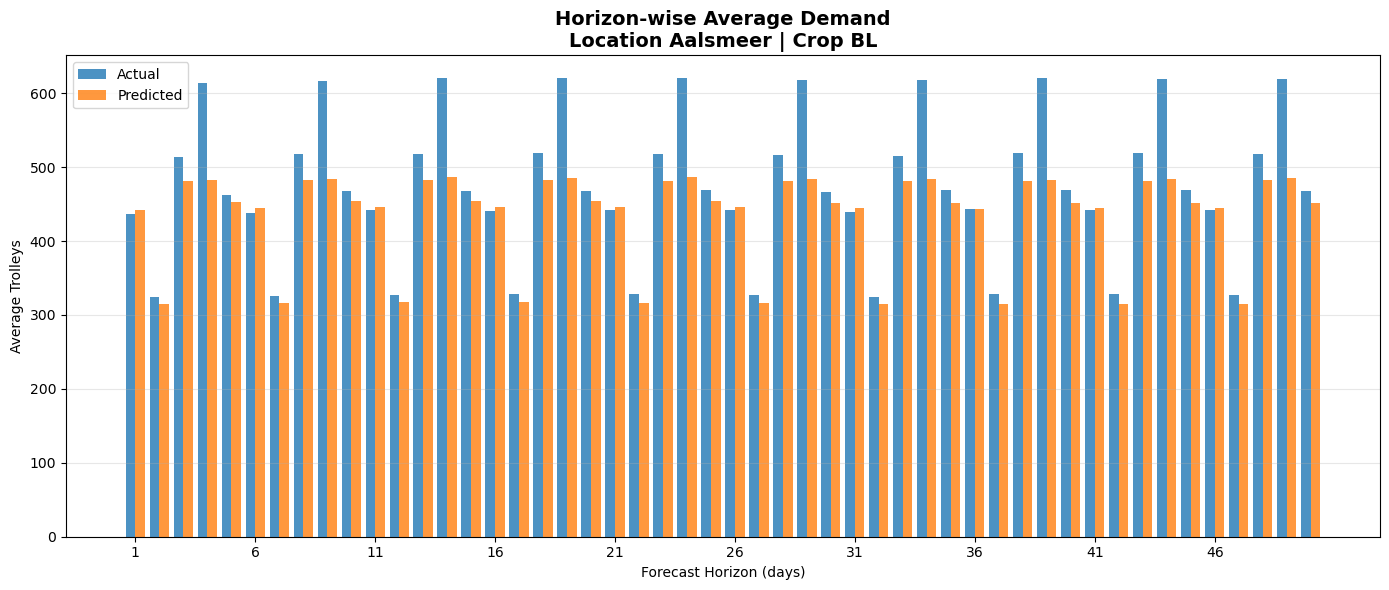

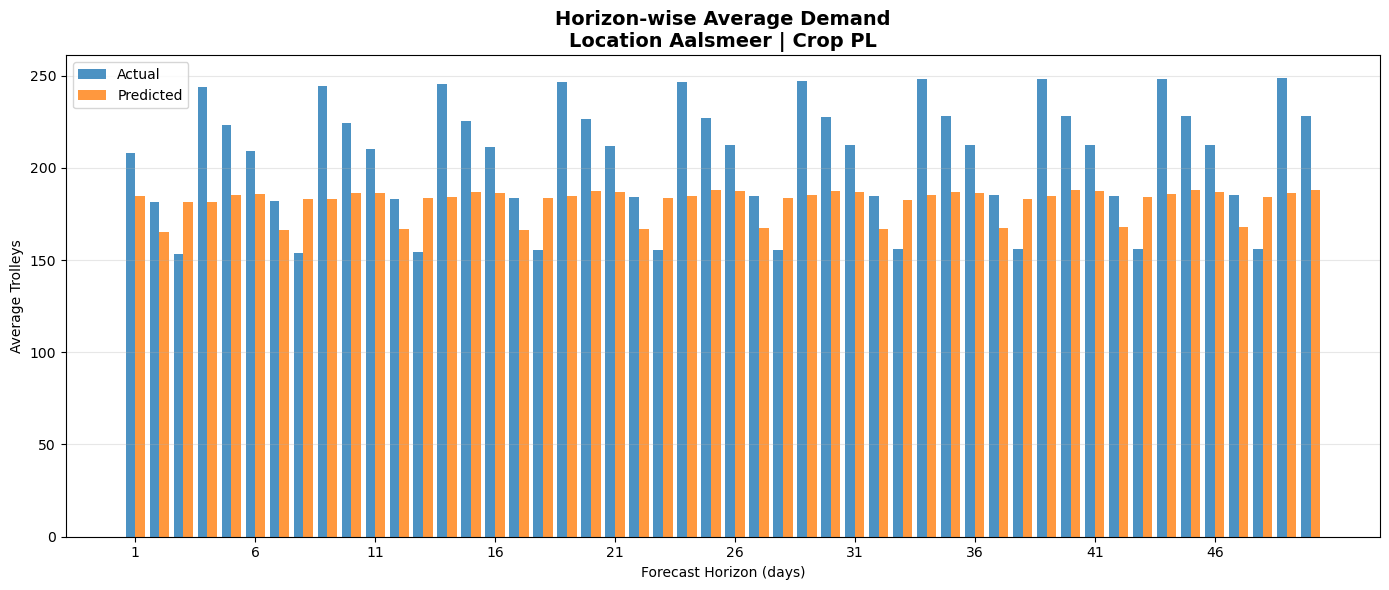

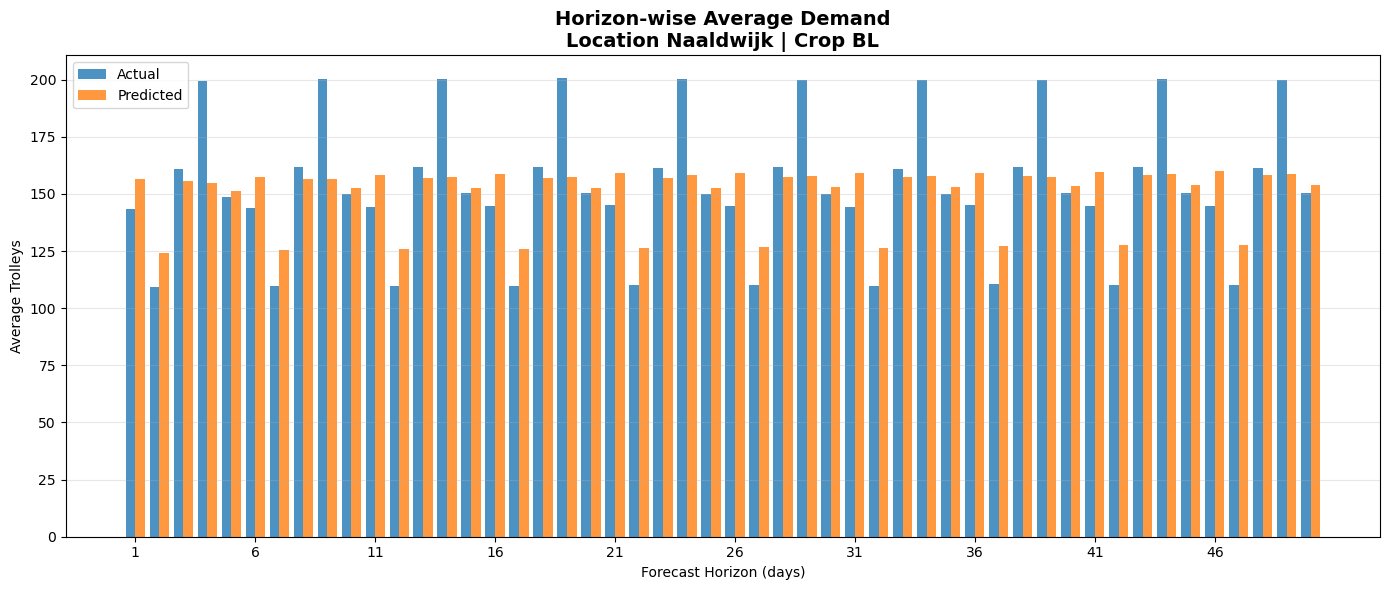

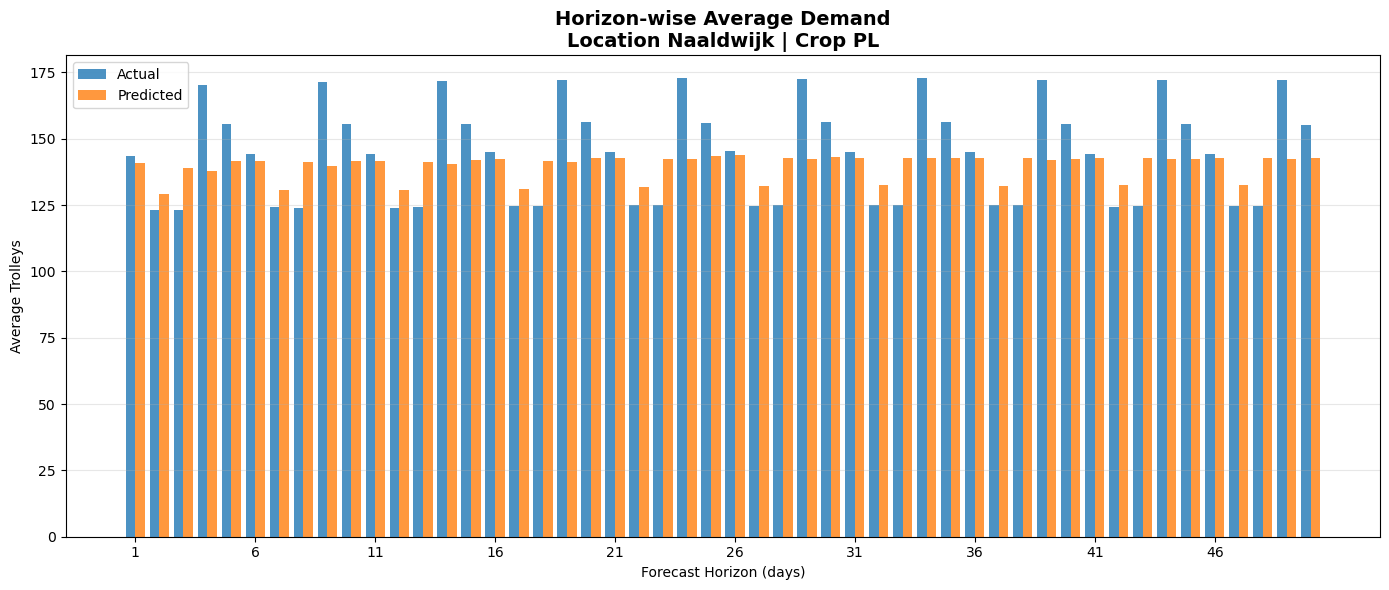

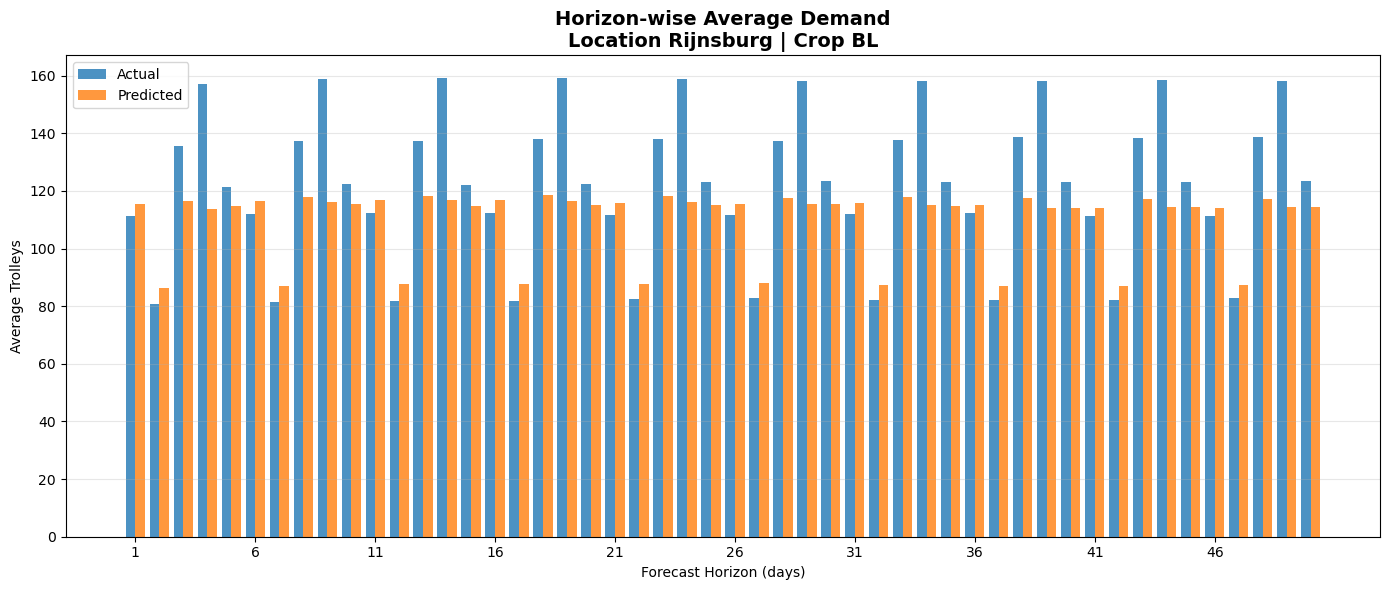

In [36]:

# -------------------------------------------------------------------
# Bar charts per location × crop (horizons 1–50)
# -------------------------------------------------------------------

HORIZONS = range(1, 51)

group_cols = ["logistieke location id", "crop_type"]
groups = (
    final_df
    .groupby(group_cols)
    .size()
    .reset_index()[group_cols]
)

print(f"Plotting {len(groups)} horizon bar charts")

for _, row in groups.iterrows():
    loc = row["logistieke location id"]
    crop = row["crop_type"]

    subset = final_df[
        (final_df["logistieke location id"] == loc) &
        (final_df["crop_type"] == crop) &
        (final_df["horizon"].isin(HORIZONS))
    ]

    if subset.empty:
        continue

    # Aggregate across dates → mean per horizon
    horizon_agg = (
        subset
        .groupby("horizon", as_index=False)
        .agg({
            "trolleys_target": "mean",
            "rf_pred_raw": "mean"
        })
        .sort_values("horizon")
    )

    x = horizon_agg["horizon"].values
    width = 0.4

    fig, ax = plt.subplots(figsize=(14, 6))

    ax.bar(
        x - width / 2,
        horizon_agg["trolleys_target"],
        width=width,
        label="Actual",
        alpha=0.8
    )

    ax.bar(
        x + width / 2,
        horizon_agg["rf_pred_raw"],
        width=width,
        label="Predicted",
        alpha=0.8
    )

    ax.set_title(
        f"Horizon-wise Average Demand\nLocation {loc} | Crop {crop}",
        fontsize=14,
        fontweight="bold"
    )

    ax.set_xlabel("Forecast Horizon (days)")
    ax.set_ylabel("Average Trolleys")
    ax.set_xticks(range(1, 51, 5))
    ax.grid(axis="y", alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()


FPC-level: MAE 49.7 | RMSE 101.5


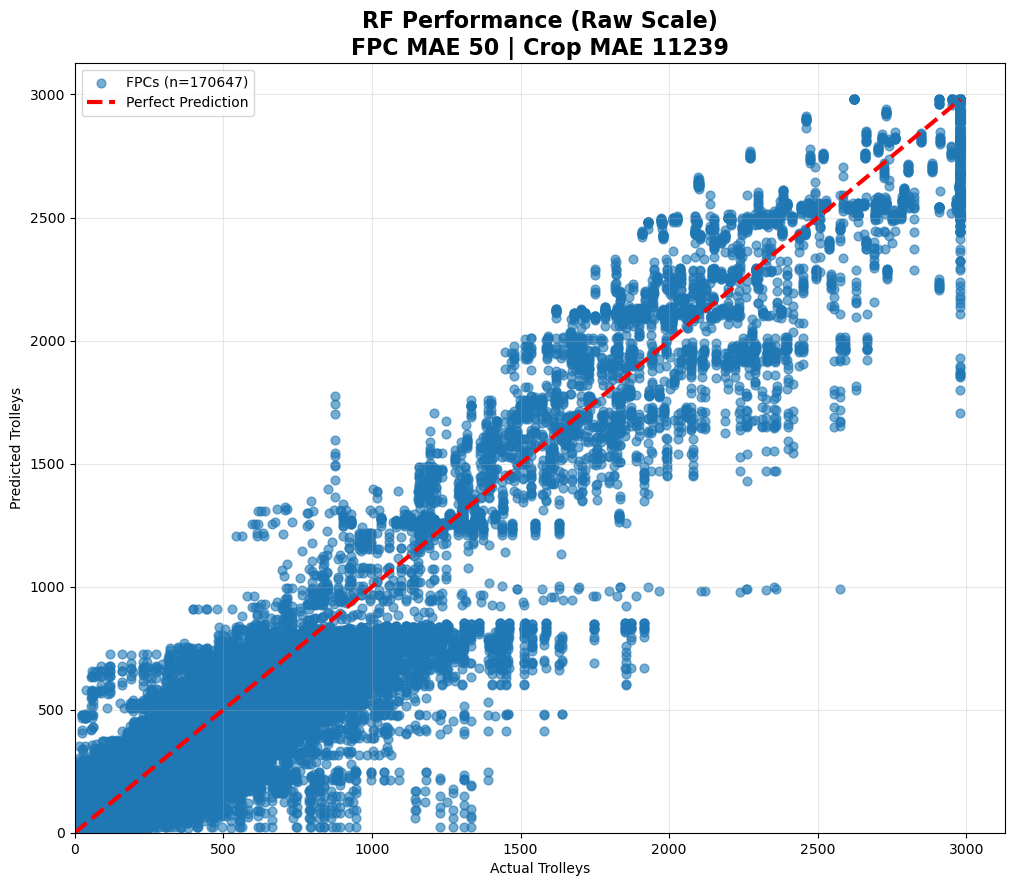


Creating dense time series plots...


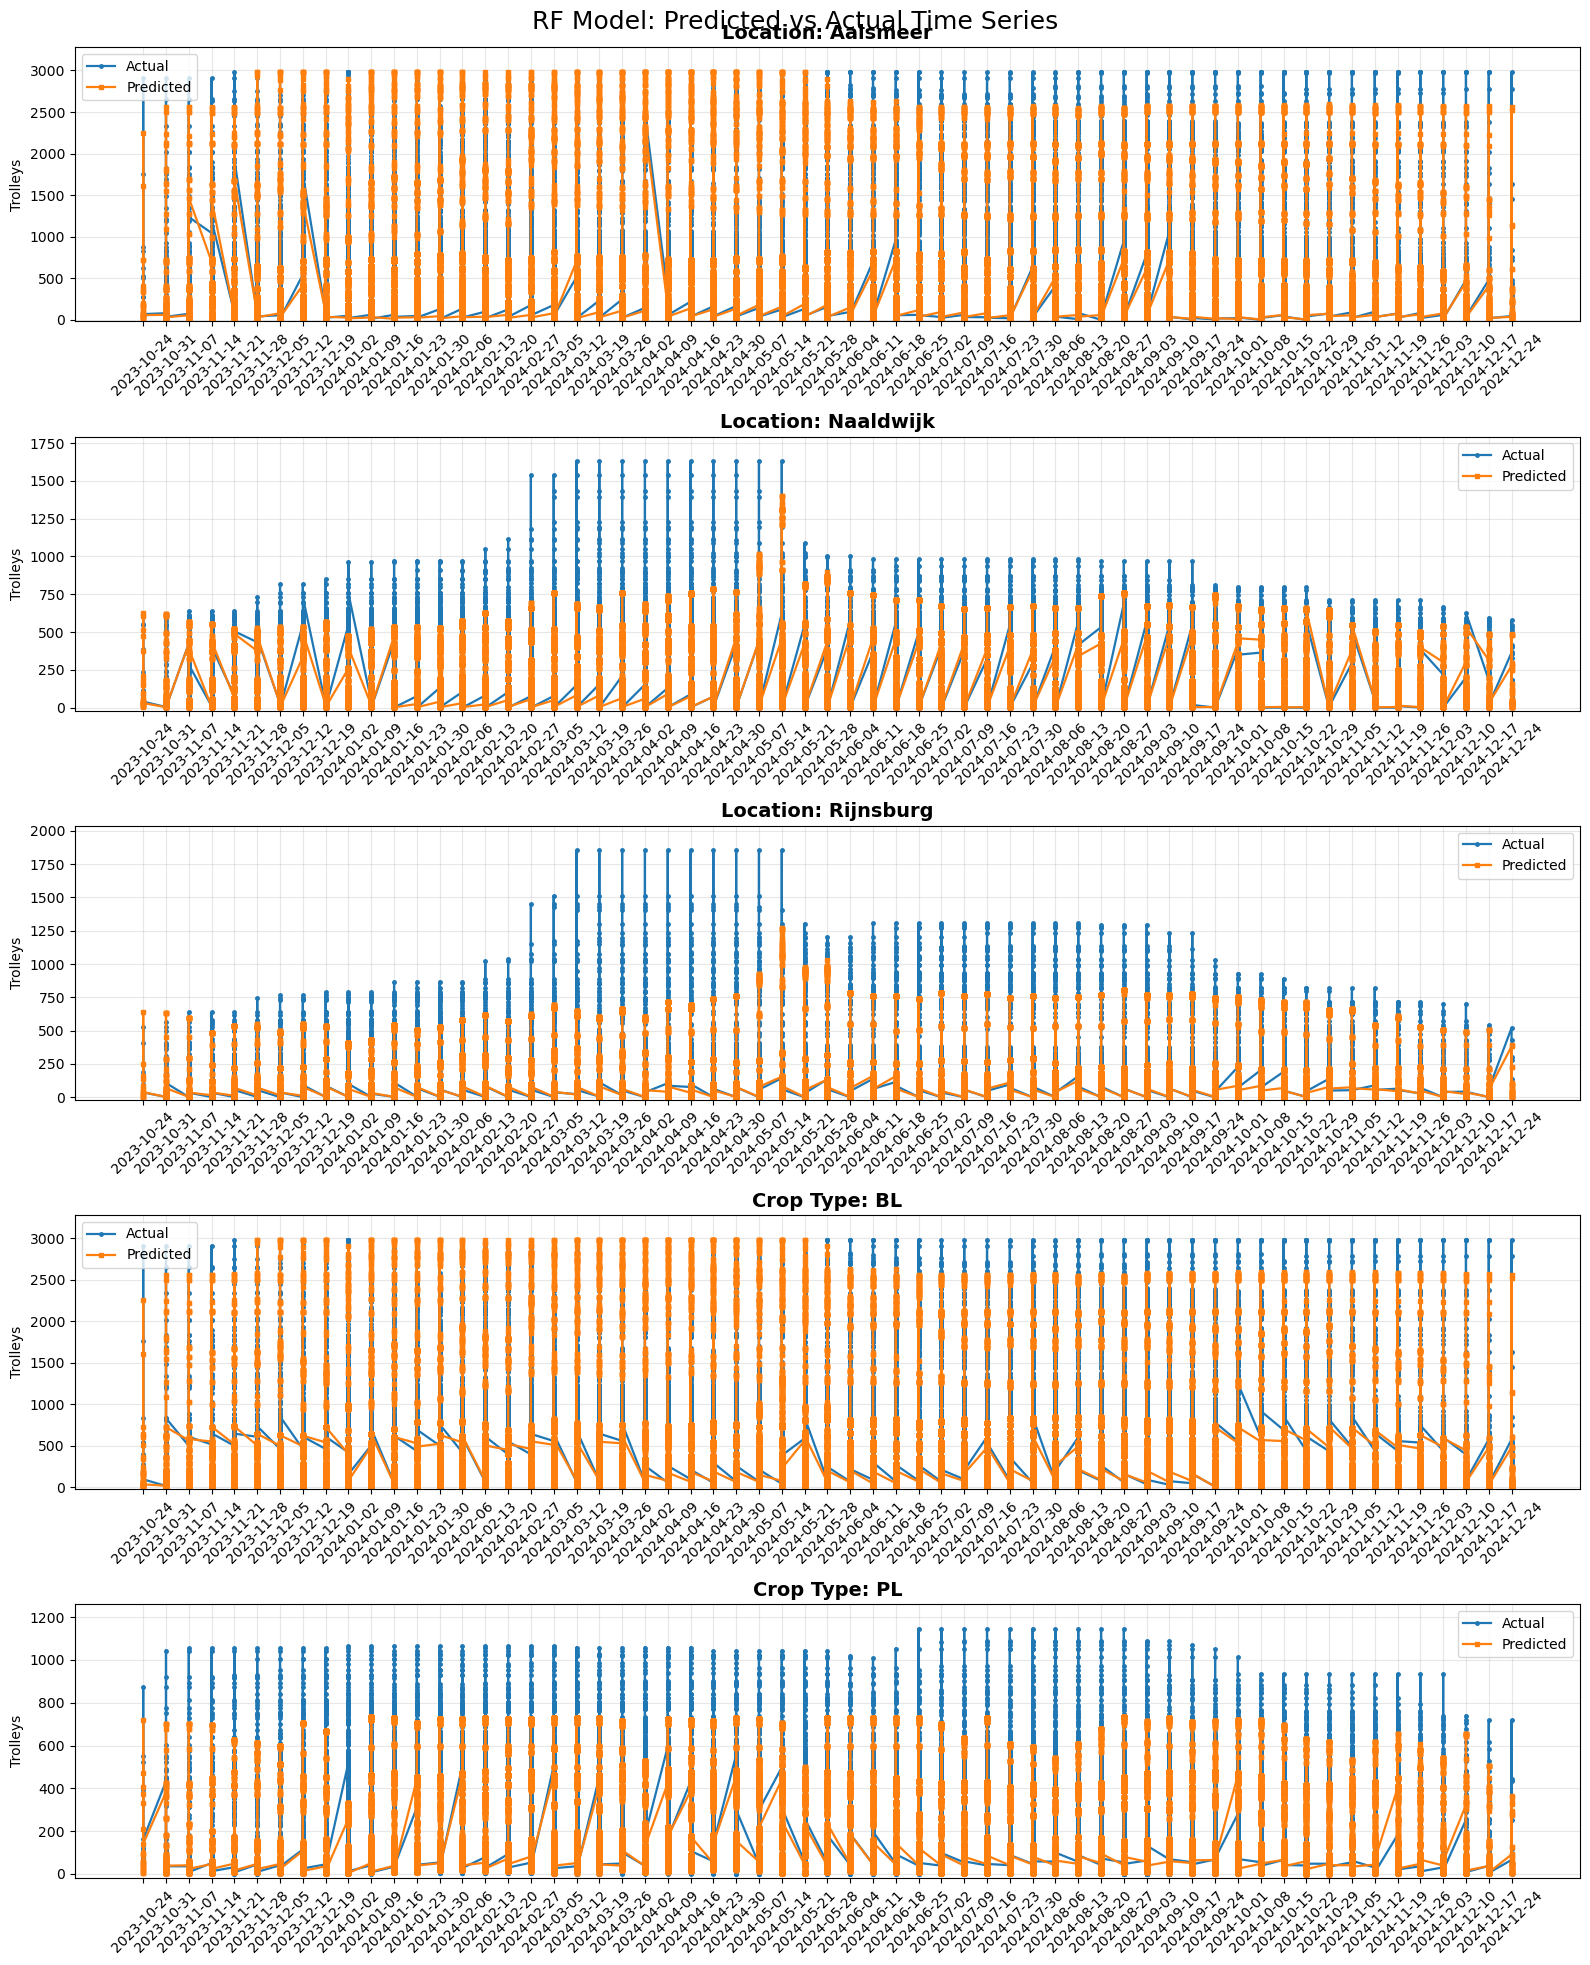


VISUALS SAVED:
  - rf_scatter_raw.png
  - rf_timeseries_dense.png


In [39]:
# -------------------------------------------------------------------
# 7. Calculate metrics (consistent with log-space pipeline)
# -------------------------------------------------------------------

# =========================
# FPC-LEVEL METRICS (RAW)
# =========================

fpc_metrics = regression_metrics(
    test_with_preds["y_true_raw"],
    test_with_preds["rf_pred_raw"],
    compute_mape=False
)

print(f"FPC-level: MAE {fpc_metrics['MAE']:.1f} | RMSE {fpc_metrics['RMSE']:.1f}")

# =========================
# CROP + LOCATION AGGREGATION
# =========================

group_cols = ["date", "logistieke location id", "crop_type"]

agg_test = (
    test_with_preds
    .groupby(group_cols, as_index=False)
    .agg({
        "y_true_raw": "sum",
        "rf_pred_raw": "sum"
    })
)

# Crop-level metrics (MAPE included)
crop_metrics = regression_metrics(
    agg_test["y_true_raw"],
    agg_test["rf_pred_raw"],
    compute_mape=True
)

# -------------------------------------------------------------------
# VISUALIZATIONS — RAW TROLLEY SCALE
# -------------------------------------------------------------------

# =========================
# 1. SCATTER PLOT (RAW)
# =========================

fig, ax = plt.subplots(figsize=(12, 10))

actual_raw = test_with_preds["y_true_raw"].values
pred_raw = test_with_preds["rf_pred_raw"].values

valid_mask = np.isfinite(actual_raw) & np.isfinite(pred_raw)

ax.scatter(
    actual_raw[valid_mask],
    pred_raw[valid_mask],
    alpha=0.6,
    s=40,
    label=f'FPCs (n={valid_mask.sum()})'
)

max_val = max(
    actual_raw[valid_mask].max(),
    pred_raw[valid_mask].max()
)

ax.plot([0, max_val], [0, max_val], 'r--', lw=3, label='Perfect Prediction')

ax.set_xlim(0, max_val * 1.05)
ax.set_ylim(0, max_val * 1.05)

ax.set_title(
    f'RF Performance (Raw Scale)\n'
    f'FPC MAE {fpc_metrics["MAE"]:.0f} | '
    f'Crop MAE {crop_metrics["MAE"]:.0f}',
    fontsize=16,
    fontweight='bold'
)

ax.set_xlabel("Actual Trolleys")
ax.set_ylabel("Predicted Trolleys")
ax.legend()
ax.grid(alpha=0.3)

plt.savefig('rf_scatter_raw.png', dpi=300, bbox_inches='tight')
plt.show()

# =========================
# 2. TIME SERIES (TOP LOCATIONS & CROPS)
# =========================

print("\nCreating dense time series plots...")

top_locations = (
    test_with_preds
    .groupby("logistieke location id")
    .size()
    .nlargest(3)
    .index
    .tolist()
)

top_crops = (
    test_with_preds
    .groupby("crop_type")
    .size()
    .nlargest(2)
    .index
    .tolist()
)

plot_configs = (
    [("location", loc) for loc in top_locations] +
    [("crop", crop) for crop in top_crops]
)

fig, axes = plt.subplots(len(plot_configs), 1, figsize=(16, 20))
fig.suptitle(
    'RF Model: Predicted vs Actual Time Series',
    fontsize=18,
    y=0.98
)

for ax, (ptype, value) in zip(axes, plot_configs):

    if ptype == "location":
        mask = test_with_preds["logistieke location id"] == value
        title = f"Location: {value}"
    else:
        mask = test_with_preds["crop_type"] == value
        title = f"Crop Type: {value}"

    plot_data = (
        test_with_preds.loc[mask, ["date", "y_true_raw", "rf_pred_raw"]]
        .sort_values("date")
    )

    ax.plot(
        plot_data["date"],
        plot_data["y_true_raw"],
        "o-",
        linewidth=1.6,
        markersize=2.5,
        label="Actual"
    )

    ax.plot(
        plot_data["date"],
        plot_data["rf_pred_raw"],
        "s-",
        linewidth=1.6,
        markersize=2.5,
        label="Predicted"
    )

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylabel("Trolleys")
    ax.legend()
    ax.grid(alpha=0.3)
    ax.tick_params(axis="x", rotation=45)

    ymax = max(
        plot_data["y_true_raw"].max(),
        plot_data["rf_pred_raw"].max()
    )
    ax.set_ylim(-20, ymax * 1.1)

plt.tight_layout()
plt.savefig('rf_timeseries_dense.png', dpi=300, bbox_inches='tight')
plt.show()


print("\nVISUALS SAVED:")
print("  - rf_scatter_raw.png")
print("  - rf_timeseries_dense.png")


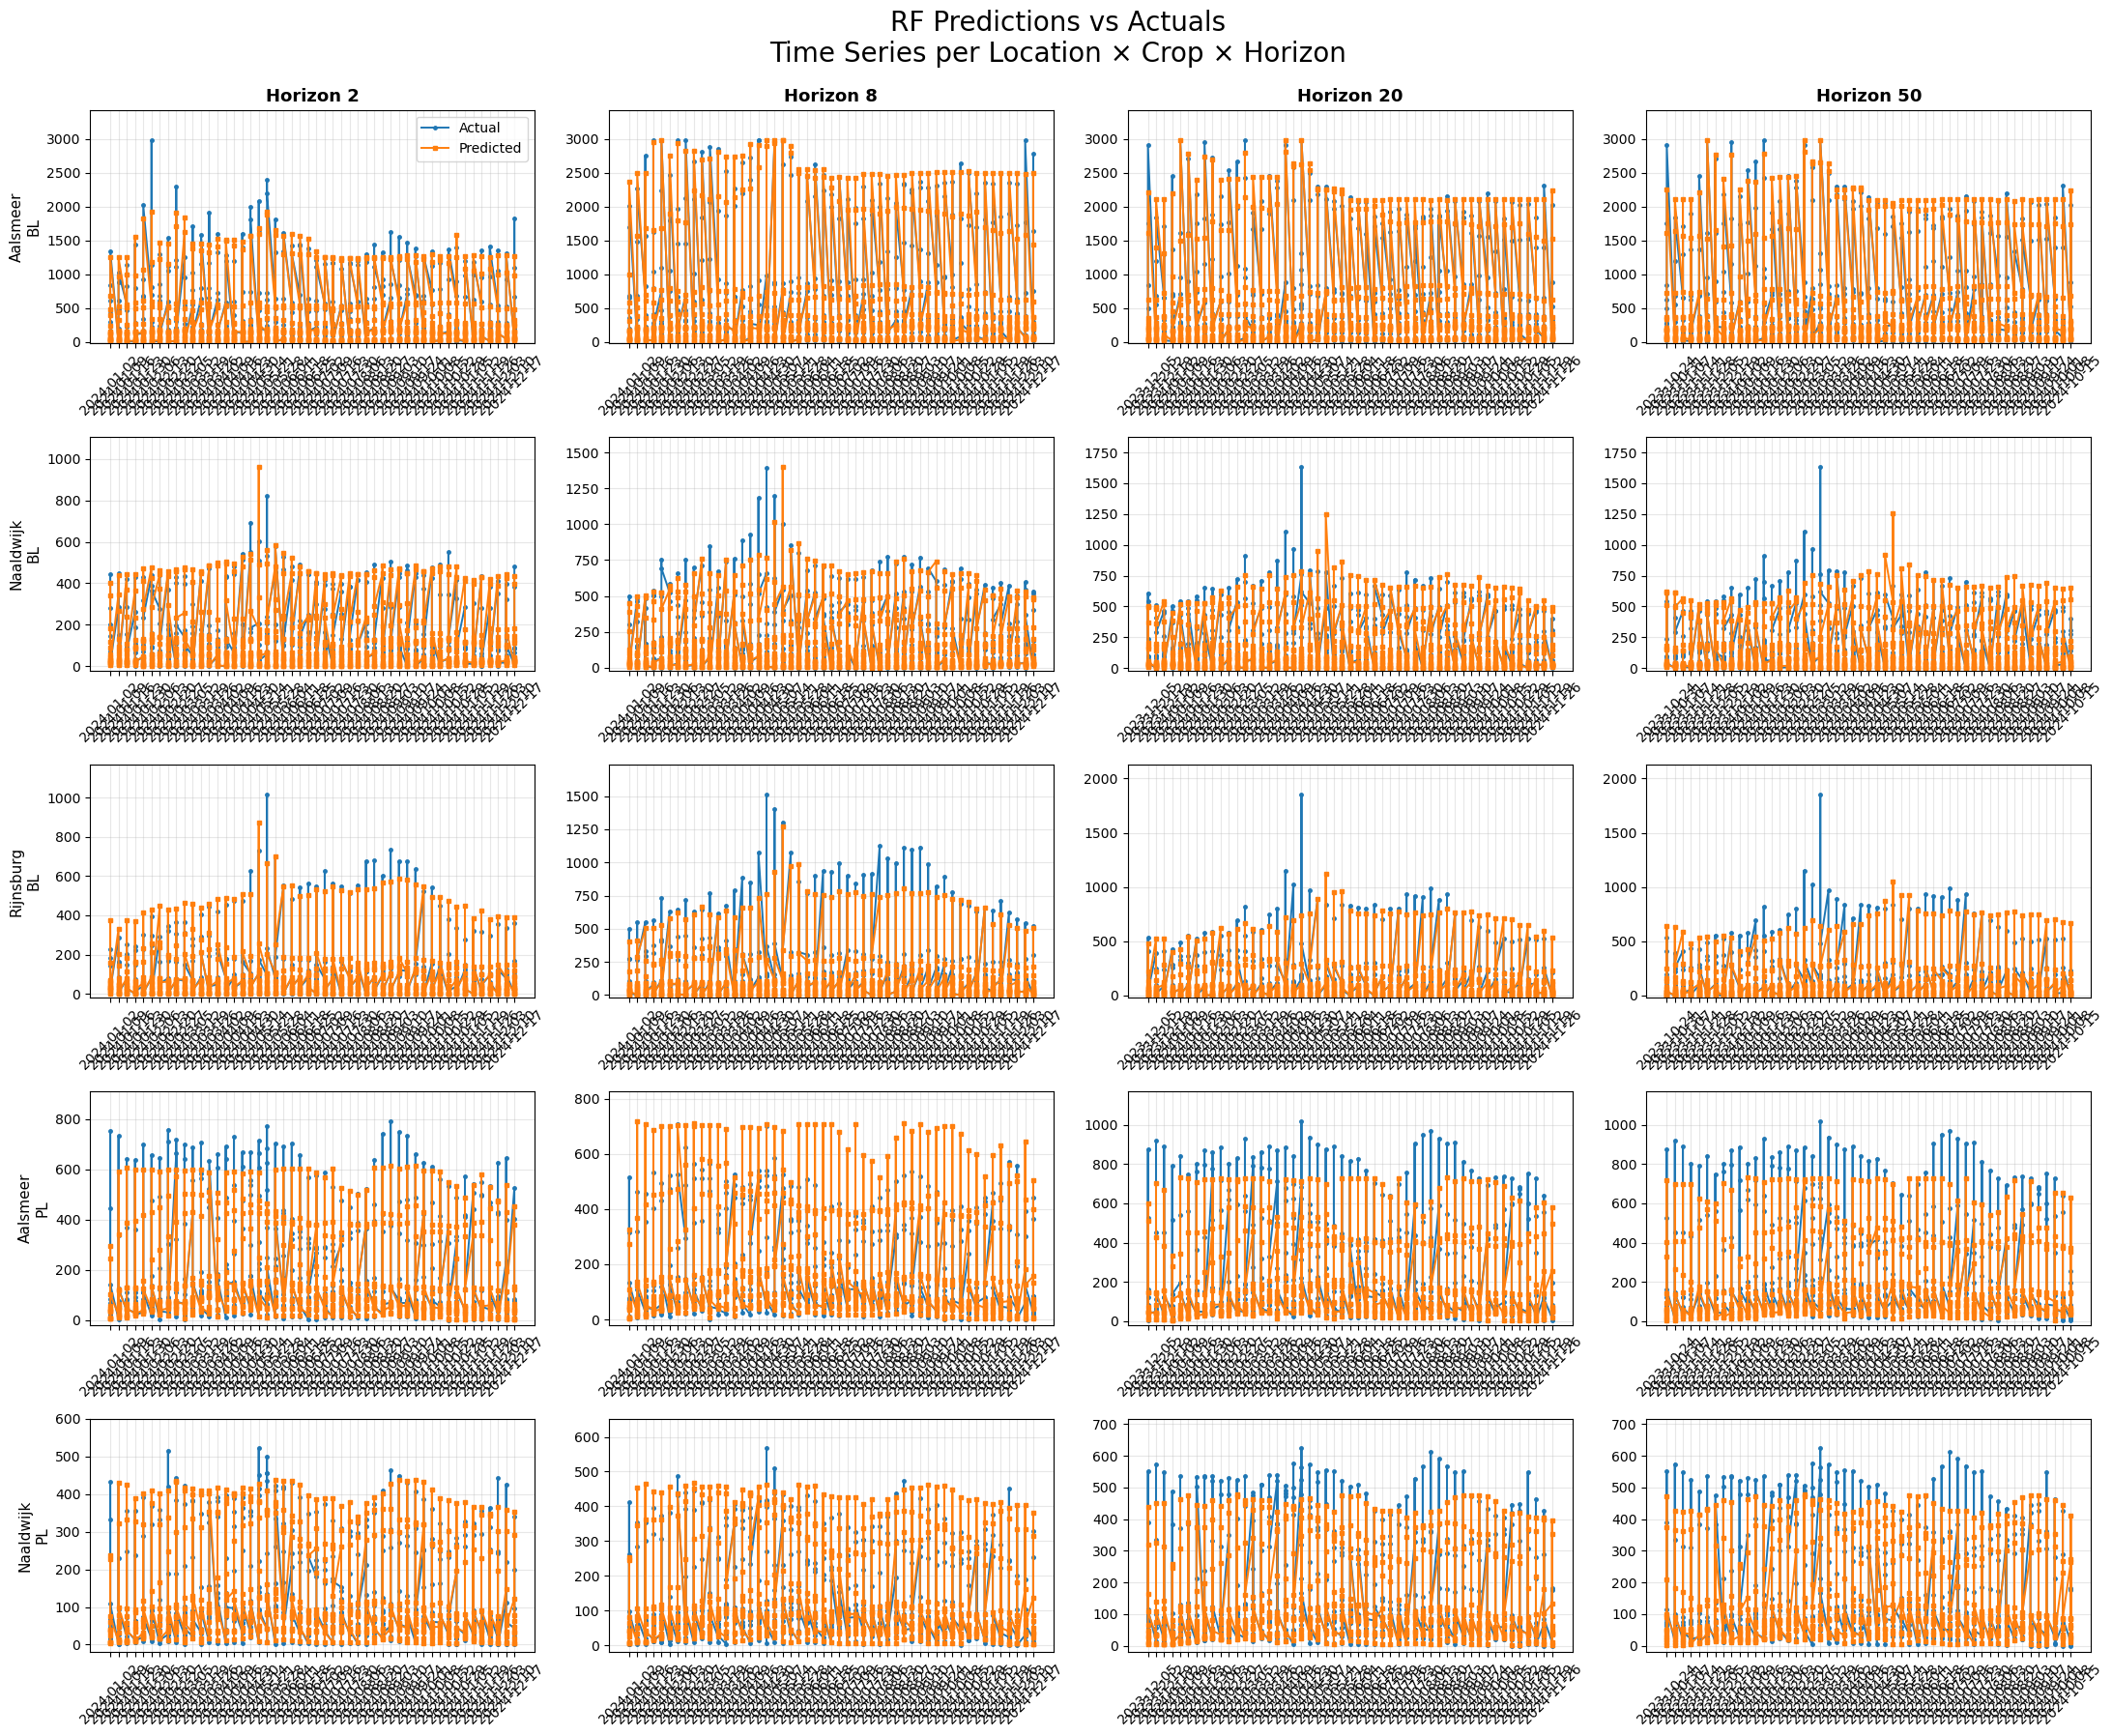

In [38]:
# Select top 5 location–crop combinations by data volume
top_pairs = (
    test_with_preds
    .groupby(["logistieke location id", "crop_type"])
    .size()
    .nlargest(5)
    .index
    .tolist()
)

horizons_to_plot = [2, 8, 20, 50]
fig, axes = plt.subplots(
    nrows=len(top_pairs),
    ncols=len(horizons_to_plot),
    figsize=(22, 18),
    sharex=False,
    sharey=False
)

fig.suptitle(
    "RF Predictions vs Actuals\nTime Series per Location × Crop × Horizon",
    fontsize=20,
    y=0.995
)

for row_idx, (loc, crop) in enumerate(top_pairs):
    for col_idx, horizon in enumerate(horizons_to_plot):

        ax = axes[row_idx, col_idx]

        mask = (
            (test_with_preds["logistieke location id"] == loc) &
            (test_with_preds["crop_type"] == crop) &
            (test_with_preds["horizon"] == horizon)
        )

        plot_data = (
            test_with_preds.loc[mask, ["date", "y_true_raw", "rf_pred_raw"]]
            .sort_values("date")
        )

        if plot_data.empty:
            ax.set_visible(False)
            continue

        ax.plot(
            plot_data["date"],
            plot_data["y_true_raw"],
            "o-",
            linewidth=1.4,
            markersize=2.5,
            label="Actual"
        )

        ax.plot(
            plot_data["date"],
            plot_data["rf_pred_raw"],
            "s-",
            linewidth=1.4,
            markersize=2.5,
            label="Predicted"
        )

        # Titles
        if row_idx == 0:
            ax.set_title(f"Horizon {horizon}", fontsize=13, fontweight="bold")

        if col_idx == 0:
            ax.set_ylabel(f"{loc}\n{crop}", fontsize=11)

        ax.grid(alpha=0.3)
        ax.tick_params(axis="x", rotation=45)

        ymax = max(
            plot_data["y_true_raw"].max(),
            plot_data["rf_pred_raw"].max()
        )
        ax.set_ylim(-20, ymax * 1.15)

        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig("rf_timeseries_location_crop_horizon.png", dpi=300, bbox_inches="tight")
plt.show()